# <b> Debt, GDP and Export analysis in G20 Country

In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
from functools import reduce
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns

The main goal of this project is to "snapshot" and understand the global debt landscape using data. You'll not only find out who owes the most, but also analyze how heavy that debt burden is for a country and how it's trending over time.

Key Questions to Answer

1. Who are the Biggest Borrowers?
2. Which countries have the largest total external debt in absolute terms (in US dollars)?
3. How has this ranking changed over the past two decades?
4. How Heavy is the Debt Burden?
5. Which countries have the highest debt-to-GDP ratio?
6. What is the ratio of debt to export revenue?
7. What is the Composition of Debt?
8. What percentage of debt is short-term versus long-term? Short-term debt is riskier because it must be repaid quickly.

## Dataset Preparation

#### <b> import debt, export, gdp and payment indicator

In [158]:
df_totalDebt = pd.read_csv("WB_WDI_DT_DOD_DECT_CD.csv")
df_shortTerm = pd.read_csv("WB_WDI_DT_DOD_DSTC_CD.csv")
df_longTerm = pd.read_csv("WB_WDI_DT_DOD_DLXF_CD.csv")
df_gdp = pd.read_csv("WB_WDI_NY_GDP_MKTP_CD.csv")
df_export = pd.read_csv("WB_WDI_BX_GSR_TOTL_CD.csv")
df_debt_service = pd.read_csv("WB_WDI_DT_TDS_DECT_CD.csv")
df_debt_to_export_ratio = pd.read_csv("WB_WDI_DT_TDS_DECT_EX_ZS.csv")

all datasets are provided by https://data.worldbank.org, we use debt, GDP, and export indicators to work on this EDA

#### <b> Identify aggregate name in dataset

In [159]:
# Aggregate data in World bank dataset
aggregate_names = [
    'Arab World', 'Caribbean small states', 'Central Europe and the Baltics', 'East Asia & Pacific',
    'East Asia & Pacific (excluding high income)', 'East Asia & Pacific (IDA & IBRD countries)',
    'Euro area', 'Europe & Central Asia', 'Europe & Central Asia (excluding high income)',
    'Europe & Central Asia (IDA & IBRD countries)', 'European Union', 'Heavily indebted poor countries (HIPC)',
    'High income', 'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only', 'IDA total', 'Late-demographic dividend',
    'Latin America & Caribbean', 'Latin America & Caribbean (excluding high income)',
    'Latin America & the Caribbean (IDA & IBRD countries)', 'Least developed countries: UN classification',
    'Low & middle income', 'Low income', 'Lower middle income', 'Middle East & North Africa',
    'Middle East & North Africa (excluding high income)', 'Middle East & North Africa (IDA & IBRD countries)',
    'Middle income', 'North America', 'OECD members', 'Other small states', 'Pacific island small states',
    'Post-demographic dividend', 'Pre-demographic dividend', 'Small states', 'South Asia',
    'South Asia (IDA & IBRD)', 'Sub-Saharan Africa', 'Sub-Saharan Africa (excluding high income)',
    'Sub-Saharan Africa (IDA & IBRD countries)', 'Upper middle income', 'World'
]

def process_wb_data(df, value_name):
    # Extract important value from each individual dataset
    country_col = 'Country Name' if 'Country Name' in df.columns else 'REF_AREA_NAME'
    time_col = 'Time' if 'Time' in df.columns else 'TIME_PERIOD'
    value_col = 'Value' if 'Value' in df.columns else 'OBS_VALUE'
    
    # Remove aggregate data
    df_filtered = df[~df[country_col].isin(aggregate_names)]
    
    # Picked and rename extracted value
    df_renamed = df_filtered[[country_col, time_col, value_col]].rename(columns={
        country_col: 'Country',
        time_col: 'Year',
        value_col: value_name
    })
    return df_renamed

Since the goal is a country-by-country analysis, regional indicator data is not needed, so it was decided to remove it.

These datasets share the same column naming structure,     
```REF_AREA_NAME``` represents the country     
```TIME_PERIOD``` represents the year     
```OBS_VALUE``` represents the data (e.g., gdp, means OBS_VALUE is the country's GDP in dollars)

#### <b> Remove unnecessary variabel in all dataset

In [160]:
# Process each dataset
total_debt = process_wb_data(df_totalDebt, "Total_Debt")
short_term_debt = process_wb_data(df_shortTerm, "Short_Term_Debt")
long_term_debt = process_wb_data(df_longTerm, "Long_Term_Debt")
gdp = process_wb_data(df_gdp, "GDP")
export = process_wb_data(df_export, "Export")
debt_paid = process_wb_data(df_debt_service, "Debt_paid")
debt_export_ratio = process_wb_data(df_debt_to_export_ratio, "Debt_Export_Ratio")

we only collect dataset variable that we need, and remove the rest of it

#### <b> Merge Dataset

In [161]:
# Merge each individual dataset that already processed
data_frames = [total_debt, short_term_debt, long_term_debt, gdp, export, debt_paid, debt_export_ratio]
df_merged = reduce(lambda left, right: pd.merge(left, right, on=['Country', 'Year'], how='outer'), data_frames)

After each individual dataset is filtered from unnecessary columns, the next step is to combine them into 1 complete dataset.

#### <b> Filter only G20 Country

In [162]:
# picked only G20 country
g20_countries = [
    'Argentina', 'Australia', 'Brazil', 'Canada', 'China', 'France', 'Germany', 'India',
    'Indonesia', 'Italy', 'Japan', 'Mexico', 'Russian Federation',
    'Saudi Arabia', 'South Africa', 'Korea, Rep.',
    'Turkiye', 'United Kingdom', 'United States'
]

In [163]:
# apply filter and remove non-G20
df_g20 = df_merged[
    (df_merged['Year'] >= 1970) &
    (df_merged['Country'].isin(g20_countries))
].copy()

In [164]:
df_g20.head()

,Country,Year,Total_Debt,Short_Term_Debt,Long_Term_Debt,GDP,Export,Debt_paid,Debt_Export_Ratio
445,Argentina,1970,5.893191e+09,639000000.0,5.254191e+09,3.158421e+10,NaN,1.118123e+09,NaN
446,Argentina,1971,6.353904e+09,687000000.0,5.666904e+09,3.329320e+10,NaN,1.078263e+09,NaN
447,Argentina,1972,6.893803e+09,745000000.0,5.959891e+09,3.473300e+10,NaN,1.140314e+09,NaN
448,Argentina,1973,7.374621e+09,794000000.0,6.370708e+09,5.254400e+10,NaN,1.389253e+09,NaN
449,Argentina,1974,7.798526e+09,839000000.0,6.881164e+09,7.243678e+10,NaN,1.663057e+09,NaN


We narrowed the analysis to the G20 countries because they collectively represent more than 80% of global GDP and 75% of global trade. The G20 serves as a representative sample of global conditions.

#### <b> Remove country without debt data 

In [165]:
df_final = df_g20.dropna(
    subset=['Total_Debt', 'GDP', 'Export', 'Debt_paid']
).copy()

# Tampilkan info untuk melihat berapa banyak data yang tersisa
print("Jumlah baris setelah membuang data kosong di kolom kunci:", len(df_final))

# Tampilkan beberapa baris acak untuk melihat datanya
print("\nContoh data yang siap dianalisis:")
df_final.head()

Jumlah baris setelah membuang data kosong di kolom kunci: 356

Contoh data yang siap dianalisis:


,Country,Year,Total_Debt,Short_Term_Debt,Long_Term_Debt,GDP,Export,Debt_paid,Debt_Export_Ratio
451,Argentina,1976,9.501611e+09,1.020000e+09,7.952293e+09,5.116950e+10,4.691000e+09,1.637161e+09,34.900052
452,Argentina,1977,1.167574e+10,2.724000e+09,8.533272e+09,5.678100e+10,6.738000e+09,1.871720e+09,27.778576
453,Argentina,1978,1.350766e+10,3.428000e+09,1.007966e+10,8.904945e+10,7.836000e+09,3.333144e+09,42.536295
454,Argentina,1979,2.117684e+10,6.911000e+09,1.426584e+10,6.925233e+10,9.916000e+09,2.281741e+09,23.010697
455,Argentina,1980,2.732246e+10,1.038340e+10,1.693906e+10,7.696192e+10,1.120200e+10,4.260979e+09,38.037665


The goal of our analysis was to analyze a country's debt, but there were several countries for which no debt data was available after further investigation. Therefore, it was decided to remove these countries because there was no insight into their debt that could be concluded.

## Feature Engineering

#### <b> Convert unit measurement become billion

In [166]:
columns_to_convert = [
    'Total_Debt', 'Short_Term_Debt', 'Long_Term_Debt',
    'GDP', 'Export', 'Debt_paid'
]

# each column numeric will converted into Billion USD Measurement
for col in columns_to_convert:
    df_final[f'{col}_Billion_USD'] = df_final[col] / 1e9

print("Dataset in Billion USD:")
print(df_final[['Country', 'Year', 'Total_Debt', 'Total_Debt_Billion_USD']].dropna().tail())

Dataset in Billion USD:
       Country  Year    Total_Debt  Total_Debt_Billion_USD
11349  Turkiye  2019  4.148700e+11              414.870032
11350  Turkiye  2020  4.297698e+11              429.769827
11351  Turkiye  2021  4.363701e+11              436.370123
11352  Turkiye  2022  4.579171e+11              457.917129
11353  Turkiye  2023  4.998425e+11              499.842485


To simplify the analysis, the units will be converted from USD to Billion USD, as all the numerical values in this dataset are above Billion USD.

#### <b> Debt to GDP Ratio

In [167]:
# Debt/GDP Ratio
df_final['Debt_to_GDP_Ratio'] = (df_final['Total_Debt'] / df_final['GDP']) * 100

print("Debt/GDP Ratio:")
print(df_final[['Country', 'Year', 'Debt_to_GDP_Ratio']].dropna().tail())

Debt/GDP Ratio:
       Country  Year  Debt_to_GDP_Ratio
11349  Turkiye  2019          54.516006
11350  Turkiye  2020          59.662205
11351  Turkiye  2021          53.224617
11352  Turkiye  2022          50.480413
11353  Turkiye  2023          44.698516


The debt burden is not measured by the size of the debt, but by the strength of the debt repayment capacity. The debt/GDP ratio can illustrate the proportion of a country's debt in relation to its economic strength.

#### <b> Short Term Debt Ratio

In [168]:
# Short term debt ratio to total debt
df_final['Short_Term_Debt_Ratio'] = (df_final['Short_Term_Debt'] / df_final['Total_Debt']) * 100

print("\nShort term debt ratio:")
print(df_final[['Country', 'Year', 'Short_Term_Debt_Ratio']].dropna().tail())


Short term debt ratio:
       Country  Year  Short_Term_Debt_Ratio
11349  Turkiye  2019              23.108683
11350  Turkiye  2020              25.965992
11351  Turkiye  2021              27.121472
11352  Turkiye  2022              32.451505
11353  Turkiye  2023              34.815725


short-term debt can be analyzed, we can see how a country manages risk in its debt portfolio

#### <b> Clarify variable Debt_export_Ratio

In [169]:
# Change column name
df_final.rename(columns={'Debt_Export_Ratio': 'Debt_Service_as_%_of_Exports'}, inplace=True)

print(df_final.columns)

Index(['Country', 'Year', 'Total_Debt', 'Short_Term_Debt', 'Long_Term_Debt',
       'GDP', 'Export', 'Debt_paid', 'Debt_Service_as_%_of_Exports',
       'Total_Debt_Billion_USD', 'Short_Term_Debt_Billion_USD',
       'Long_Term_Debt_Billion_USD', 'GDP_Billion_USD', 'Export_Billion_USD',
       'Debt_paid_Billion_USD', 'Debt_to_GDP_Ratio', 'Short_Term_Debt_Ratio'],
      dtype='object')


The Debt Export Ratio variable is the annual installment value (principal + interest) that must be paid that year with the total export revenue that year. For clarity, the variable name has been changed.

#### <b> Year over Year debt profile

In [170]:
# Sort data based  on Country and year
df_final = df_final.sort_values(by=['Country', 'Year'])

# Calculate GDP and Debt Growth percentage
df_final['GDP_Growth_%'] = df_final.groupby('Country')['GDP'].pct_change() * 100
df_final['Debt_Growth_%'] = df_final.groupby('Country')['Total_Debt'].pct_change() * 100

# Result
print("\nGDP and Debt Growth:")
df_final[['Country', 'Year', 'GDP_Billion_USD', 'GDP_Growth_%', 'Total_Debt_Billion_USD', 'Debt_Growth_%']].head()


GDP and Debt Growth:


,Country,Year,GDP_Billion_USD,GDP_Growth_%,Total_Debt_Billion_USD,Debt_Growth_%
451,Argentina,1976,51.169500,NaN,9.501611,NaN
452,Argentina,1977,56.781000,10.966494,11.675739,22.881682
453,Argentina,1978,89.049453,56.829666,13.507657,15.689949
454,Argentina,1979,69.252329,-22.231607,21.176835,56.776523
455,Argentina,1980,76.961924,11.132614,27.322464,29.020525


Comparing national growth is very difficult using absolute numbers. However, by using percentages, we can make fair comparisons. 5% growth is 5% growth, regardless of the size of the economy.

## Descriptive Statistics

#### <b>Remove unnecesssary column

In [171]:
columns_to_drop = [
    "Total_Debt", "Short_Term_Debt", "Long_Term_Debt",
    "GDP", "Export", "Debt_paid"
]

df_final = df_final.drop(columns=columns_to_drop)

 Since we already ```have columns_to_drop``` data with Billion USD measurement unit, we no longer needed data with USD measurement. 

#### <b> Debt/GDP Ratio statistics

In [172]:
# See Debt/GDP Ratio per country
stats_per_country = df_final.groupby('Country')

# Descriptive stats result
print("Debt to GDP Ratio Profile:")
stats_per_country['Debt_to_GDP_Ratio'].describe()

Debt to GDP Ratio Profile:


,count,mean,std,min,25%,50%,75%,max
Country,,,,,,,,
Argentina,48.0,47.682355,25.585421,15.168714,31.348821,42.098775,53.677487,151.774575
Brazil,49.0,30.305228,10.032711,15.444265,22.067997,29.103919,37.214501,55.413049
China,42.0,12.824285,3.541025,4.076250,12.093671,13.593753,15.192598,19.358376
India,49.0,19.677287,5.092000,11.121944,16.770891,19.294010,22.436441,32.700233
Indonesia,43.0,50.575873,25.493138,24.595407,33.725540,39.380532,63.031060,158.713363
Mexico,45.0,37.601730,13.224583,21.371389,26.556702,34.497965,46.735336,75.123406
South Africa,30.0,28.858322,12.116218,14.116746,17.712344,26.340091,39.985706,51.902412
Turkiye,50.0,39.302258,11.408241,10.987245,35.153377,40.302465,45.713231,59.662205


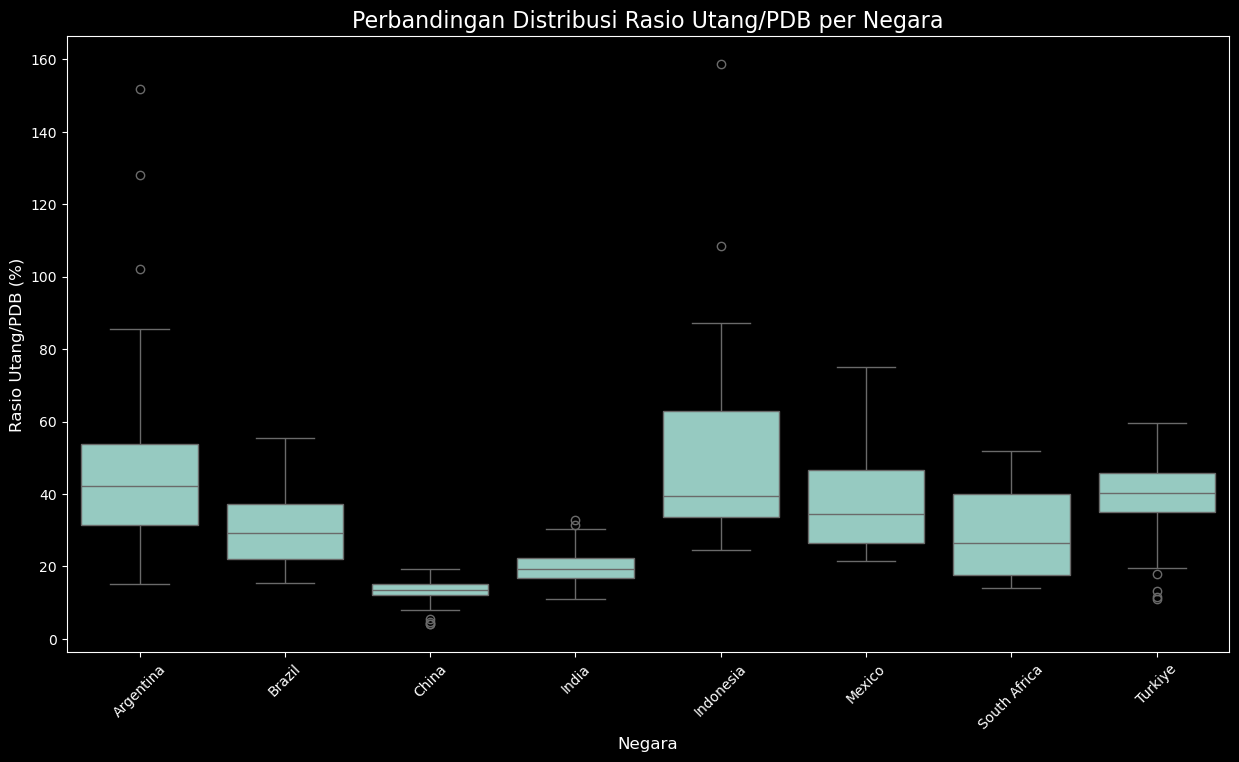

In [173]:
# Atur ukuran gambar
plt.figure(figsize=(15, 8))

# Buat box plot, dengan Negara di sumbu X dan Rasio di sumbu Y
sns.boxplot(data=df_final, x='Country', y='Debt_to_GDP_Ratio')

# Atur judul dan label
plt.title('Perbandingan Distribusi Rasio Utang/PDB per Negara', fontsize=16)
plt.xlabel('Negara', fontsize=12)
plt.ylabel('Rasio Utang/PDB (%)', fontsize=12)

# Putar label negara agar tidak tumpang tindih
plt.xticks(rotation=45)
plt.show()

<b> Country with High volatility Debt and Heavy Debt Ratio

```Argentina and Indonesia```. These two countries have the highest mean Debt/GDP ratios (47.6% and 50.5%). More importantly, they also have the highest standard deviations (both around 25.5). This indicates that their debt burdens are not only high but also highly unstable and volatile. The extreme maximum values (151% for Argentina, 158% for Indonesia) confirm that both countries have experienced periods of severe debt crises.

<b> Moderate Burden with Risk

```Brazil, Mexico, and Turkey```. These countries have a mean debt burden at a moderate level (ranging from 30-40%). Their standard deviations (std) are also moderate (around 10-13), indicating fluctuations, but not as extreme as Argentina or Indonesia. These countries are examples of countries that have consistently managed significant debt burdens.

<b> Lowest & Most Stable Debt

```China and India```. China is the most prominent case here, with a very low mean (12.8%) and std (3.5). This suggests that historically, China's debt burden relative to its massive economic size has been very small and stable. India also exhibits a similar profile, with a low burden and volatility (mean 19.6%, std 5.0).

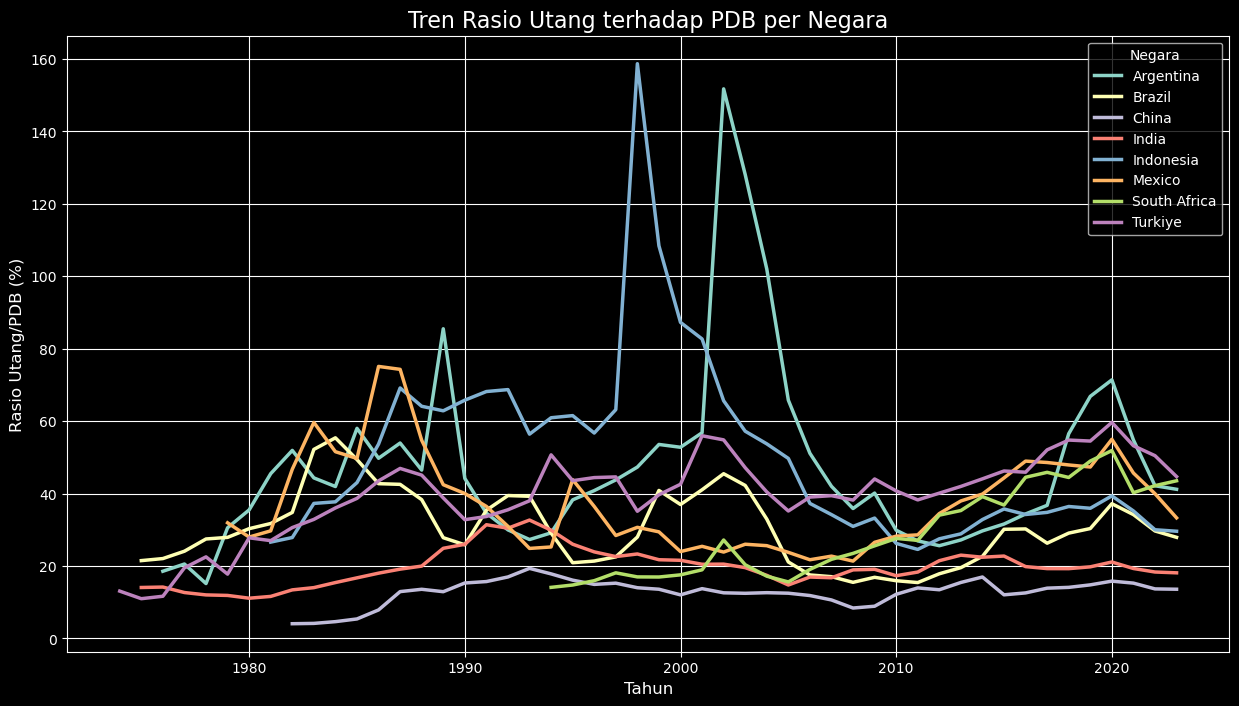

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns

# Atur ukuran gambar
plt.figure(figsize=(15, 8))

# Buat line plot menggunakan seaborn
# x = Tahun, y = Rasio Utang/PDB, dan setiap negara (hue) memiliki garis warna berbeda
sns.lineplot(data=df_final, x='Year', y='Debt_to_GDP_Ratio', hue='Country', linewidth=2.5)

# Atur judul dan label
plt.title('Tren Rasio Utang terhadap PDB per Negara', fontsize=16)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Rasio Utang/PDB (%)', fontsize=12)

# Atur legenda
plt.legend(title='Negara')
plt.grid(True)
plt.show()

#### <b> Short term debt ratio statistics

In [175]:
print("Short term debt Ratio per country")
stats_per_country['Short_Term_Debt_Ratio'].describe()

Short term debt Ratio per country


,count,mean,std,min,25%,50%,75%,max
Country,,,,,,,,
Argentina,48.0,19.655150,7.351395,6.016407,14.243097,19.347312,23.360786,38.003161
Brazil,49.0,13.638990,3.918832,6.926628,10.529404,12.737535,16.459220,21.685086
China,42.0,40.397357,19.879381,8.964622,19.954769,44.421639,53.741569,73.169607
India,49.0,11.278824,6.760717,2.755776,5.321968,10.235826,18.424844,23.778577
Indonesia,43.0,14.982339,3.542859,7.755126,12.688903,14.387298,16.776891,24.984156
Mexico,45.0,13.909249,6.989454,5.289432,9.213309,11.484452,18.350512,31.860935
South Africa,30.0,31.213381,7.359689,21.136492,25.124397,28.706082,37.564722,43.990571
Turkiye,50.0,23.343793,8.478744,8.981669,18.450527,22.283748,27.094644,53.203451


C:\Users\hilla\AppData\Local\Temp\ipykernel_24348\189088711.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




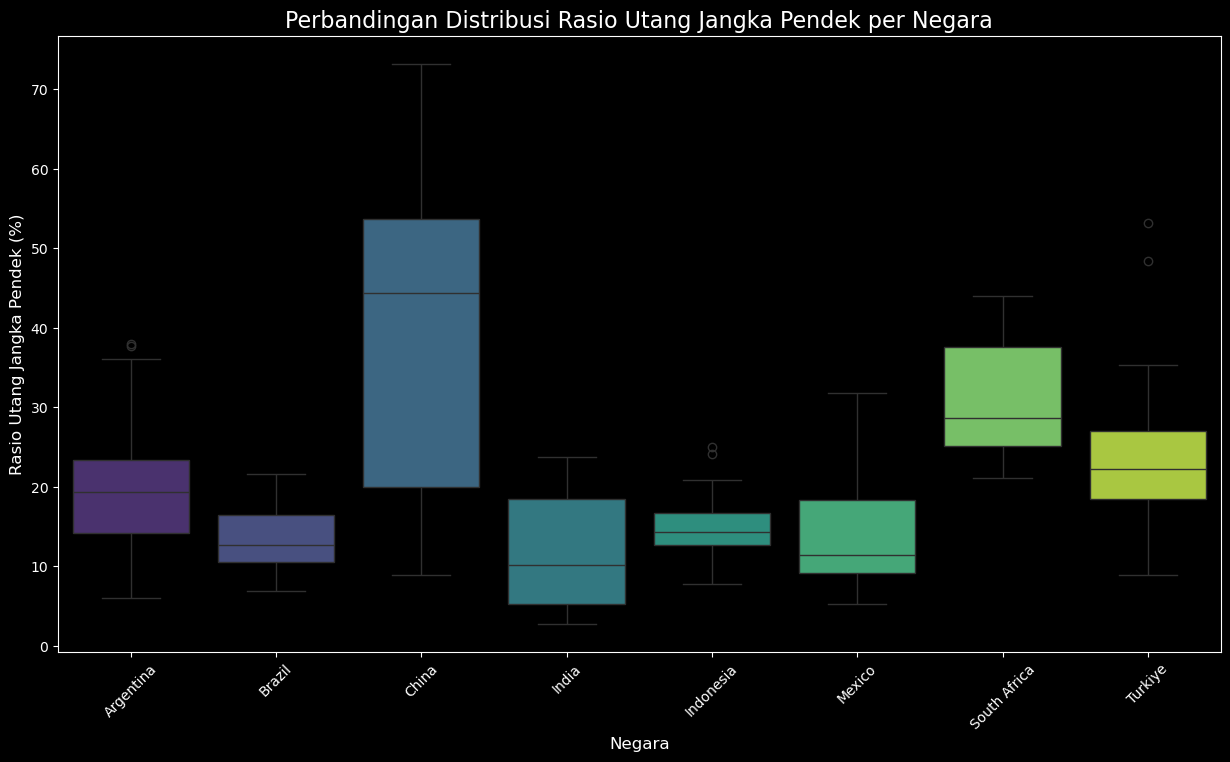

In [176]:
# Short term debt ratio boxplot
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_final, x='Country', y='Short_Term_Debt_Ratio', palette='viridis')

# Atur judul dan label
plt.title('Perbandingan Distribusi Rasio Utang Jangka Pendek per Negara', fontsize=16)
plt.xlabel('Negara', fontsize=12)
plt.ylabel('Rasio Utang Jangka Pendek (%)', fontsize=12)

# Putar label negara agar tidak tumpang tindih
plt.xticks(rotation=45)
plt.show()

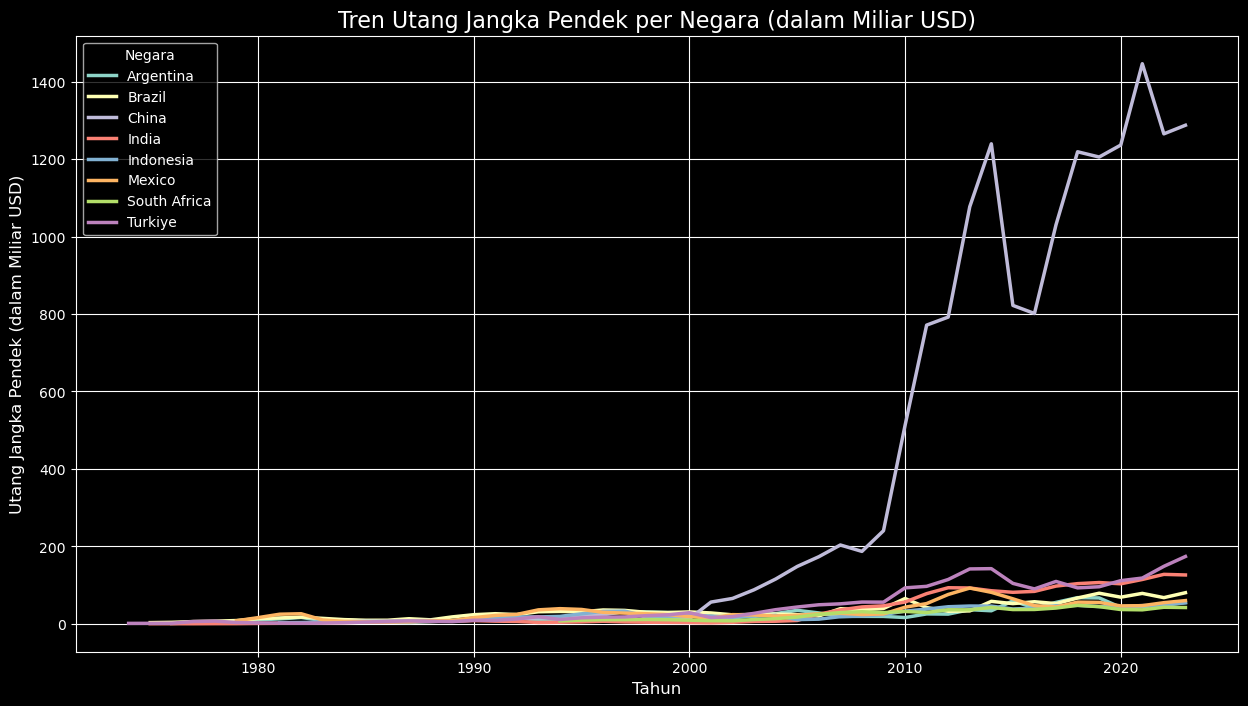

In [177]:
# Atur ukuran gambar
plt.figure(figsize=(15, 8))

# Buat line plot menggunakan seaborn
# x = Tahun, y = Utang Jangka Pendek, dan setiap negara (hue) akan memiliki garis warna berbeda
sns.lineplot(data=df_final, x='Year', y='Short_Term_Debt_Billion_USD', hue='Country', linewidth=2.5)

# Atur judul dan label
plt.title('Tren Utang Jangka Pendek per Negara (dalam Miliar USD)', fontsize=16)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Utang Jangka Pendek (dalam Miliar USD)', fontsize=12)

# Atur legenda
plt.legend(title='Negara')
plt.grid(True)
plt.show()

The debt risk structure of each country varies, with countries such as China and South Africa showing a higher reliance on risky short-term debt, in contrast to Indonesia, whose risk structure is actually very stable.

#### <b> Total Debt Statistics

In [178]:
stats_per_year = df_final.groupby('Year')

In [179]:
print("\nTotal Debt Trend by Year:")
stats_per_year['Total_Debt_Billion_USD'].describe().tail(20)


Total Debt Trend by Year:


,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2004,8.0,164.658027,64.361671,44.011450,134.442482,166.736735,212.703544,247.359209
2005,8.0,163.738988,71.851425,45.092243,128.390236,160.194299,195.829787,285.857037
2006,8.0,179.056799,80.871765,57.942874,131.707816,176.914268,218.614632,326.419520
2007,8.0,210.130947,96.156496,72.806266,141.075013,221.250996,255.161500,377.749153
2008,8.0,222.640158,99.363477,74.274061,150.875192,237.675938,270.829581,386.423097
2009,8.0,240.810149,113.024856,84.376758,167.977309,253.429054,282.738290,454.495613
2010,8.0,306.845915,197.632778,115.321956,180.369374,301.382972,325.583658,742.737476
2011,8.0,368.998391,294.700793,124.137231,200.443198,327.692745,364.782557,1054.209569
2012,8.0,413.510349,319.855443,139.877658,226.457264,372.986812,434.864818,1148.164369


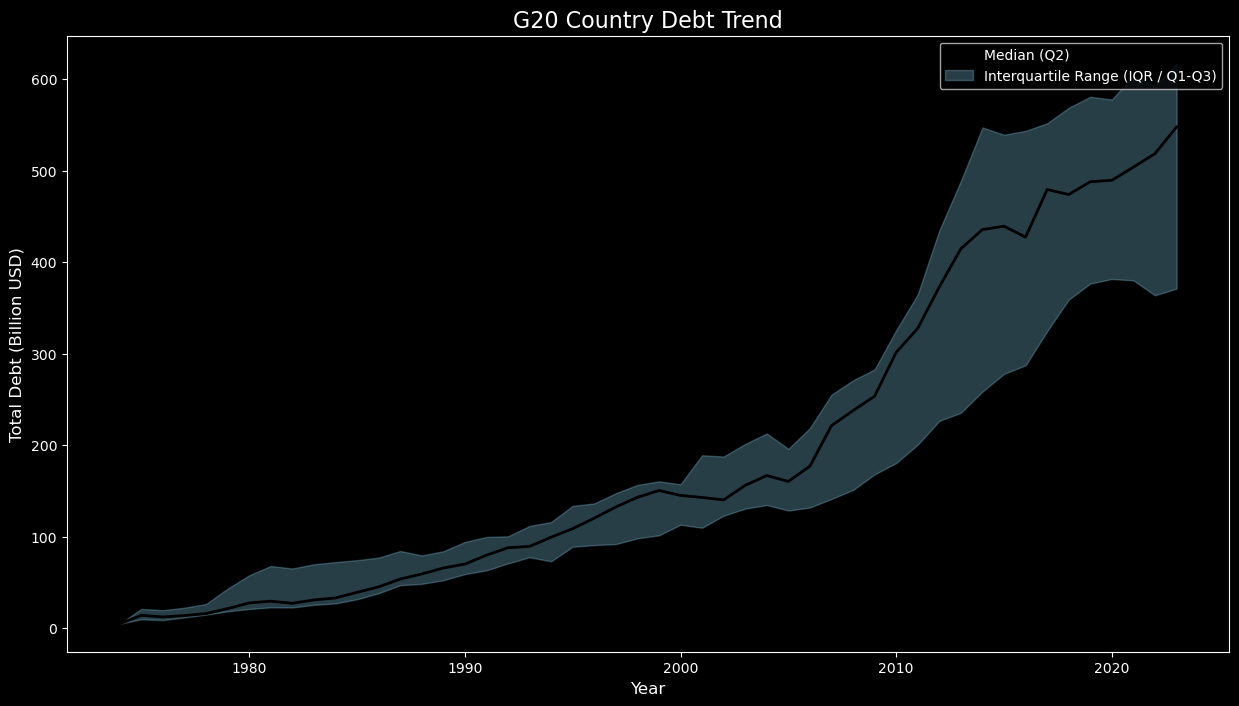

In [180]:
stats_per_year = df_final.groupby('Year')['Total_Debt_Billion_USD'].quantile([0.25, 0.5, 0.75]).unstack()


fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(stats_per_year.index, stats_per_year[0.5], label='Median (Q2)', color='black', linewidth=2)
ax.fill_between(stats_per_year.index, stats_per_year[0.25], stats_per_year[0.75], 
                alpha=0.3, color='skyblue', label='Interquartile Range (IQR / Q1-Q3)')

ax.set_title('G20 Country Debt Trend', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Total Debt (Billion USD)', fontsize=12)
ax.legend()
plt.show()

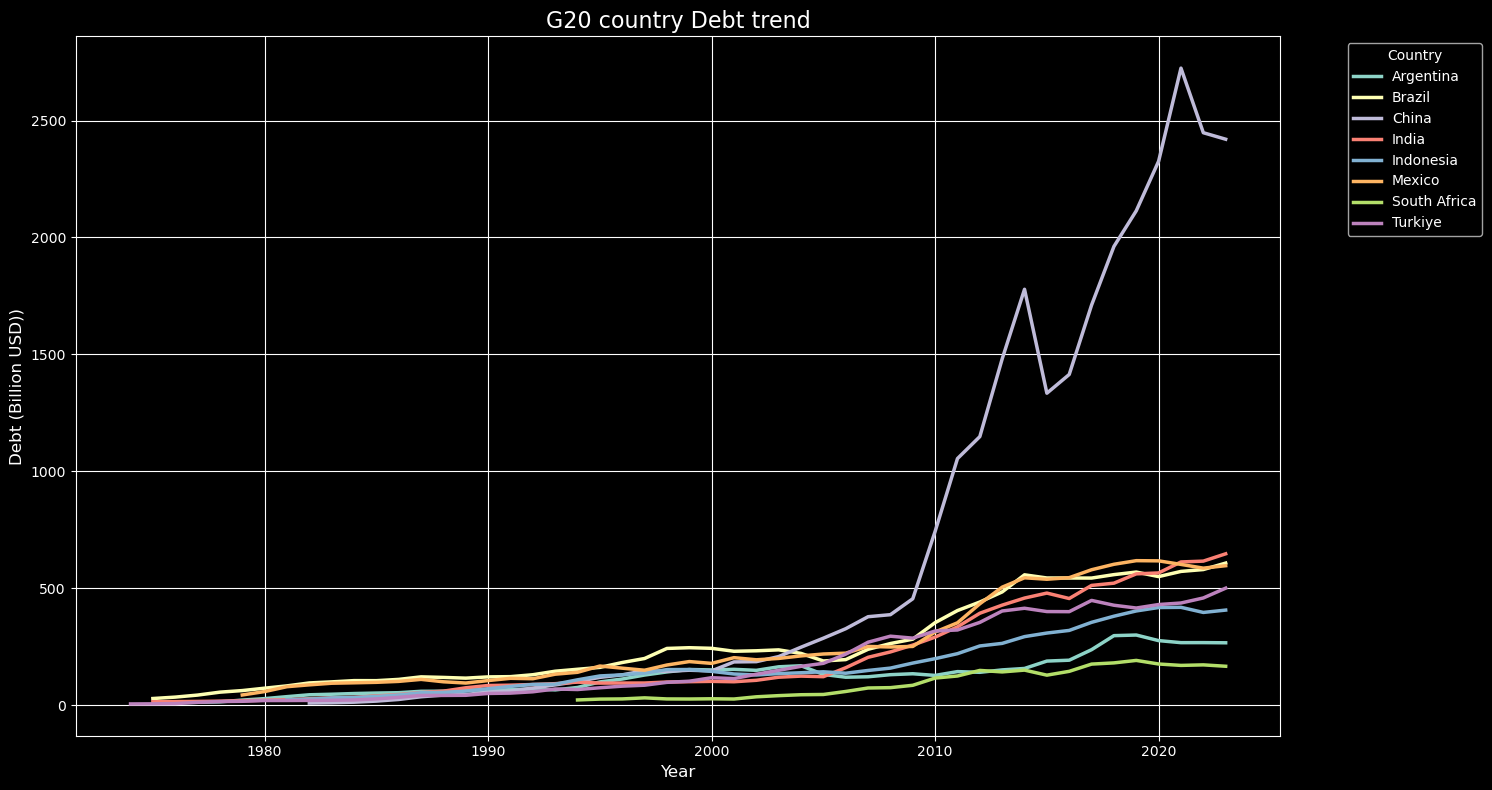

In [181]:
plt.figure(figsize=(15, 8))

# Total debt line plot
sns.lineplot(
    data=df_final, 
    x='Year', 
    y='Total_Debt_Billion_USD', 
    hue='Country', 
    linewidth=2.5
)

plt.title('G20 country Debt trend', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Debt (Billion USD))', fontsize=12)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

The debt burden relative to the economy (Debt/GDP Ratio) for the G20 developing countries collectively continues to rise and is increasingly diverse (non-uniform). Second, the dramatic increase in total absolute debt is dominated by China's extraordinary debt growth, which dwarfs the debt scale of other countries in nominal terms.

#### <b> Debt Statistics Conclusion

The debt profiles of the G20 developing countries are highly diverse and cannot be generalized. The analysis reveals a sharp contrast in scale, burden, and risk: in absolute terms, China's debt dominates massively, but its debt burden relative to GDP is among the lowest and most stable. Conversely, countries like Argentina and Indonesia exhibit historically heavy and volatile debt burdens (Debt/GDP ratios), marked by extreme crisis peaks. However, in terms of risk structure (Short-Term Debt Ratio), Indonesia has a conservative and stable profile, while China and South Africa unexpectedly show the highest reliance on riskier short-term debt.

#### <b> GDP Statistics

In [182]:
# GDP Stats per country
stats_gdp_per_country = df_final.groupby('Country')['GDP_Billion_USD'].describe()

print("GDP Descriptive statistics : ")
stats_gdp_per_country

GDP Descriptive statistics : 


,count,mean,std,min,25%,50%,75%,max
Country,,,,,,,,
Argentina,48.0,282.228914,186.842049,51.169500,108.076257,257.735875,429.659237,646.075278
Brazil,49.0,982.593608,795.648089,129.203555,283.056837,655.448232,1695.855084,2616.156224
China,42.0,4957.275237,5829.899037,205.089700,431.369605,1565.419099,9310.899679,17881.782684
India,49.0,1007.952219,1023.996538,98.473832,270.105342,458.821053,1823.051830,3567.551675
Indonesia,43.0,459.253532,419.506606,75.929618,111.381362,227.369679,891.891930,1371.171152
Mexico,45.0,748.516906,464.159984,134.531901,263.797828,765.549968,1161.553460,1789.114435
South Africa,30.0,296.253681,109.276260,129.087557,169.667526,326.669785,387.359728,458.199495
Turkiye,50.0,392.839640,343.560576,35.414286,87.796594,221.001098,768.088329,1118.252964


C:\Users\hilla\AppData\Local\Temp\ipykernel_24348\2913510025.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




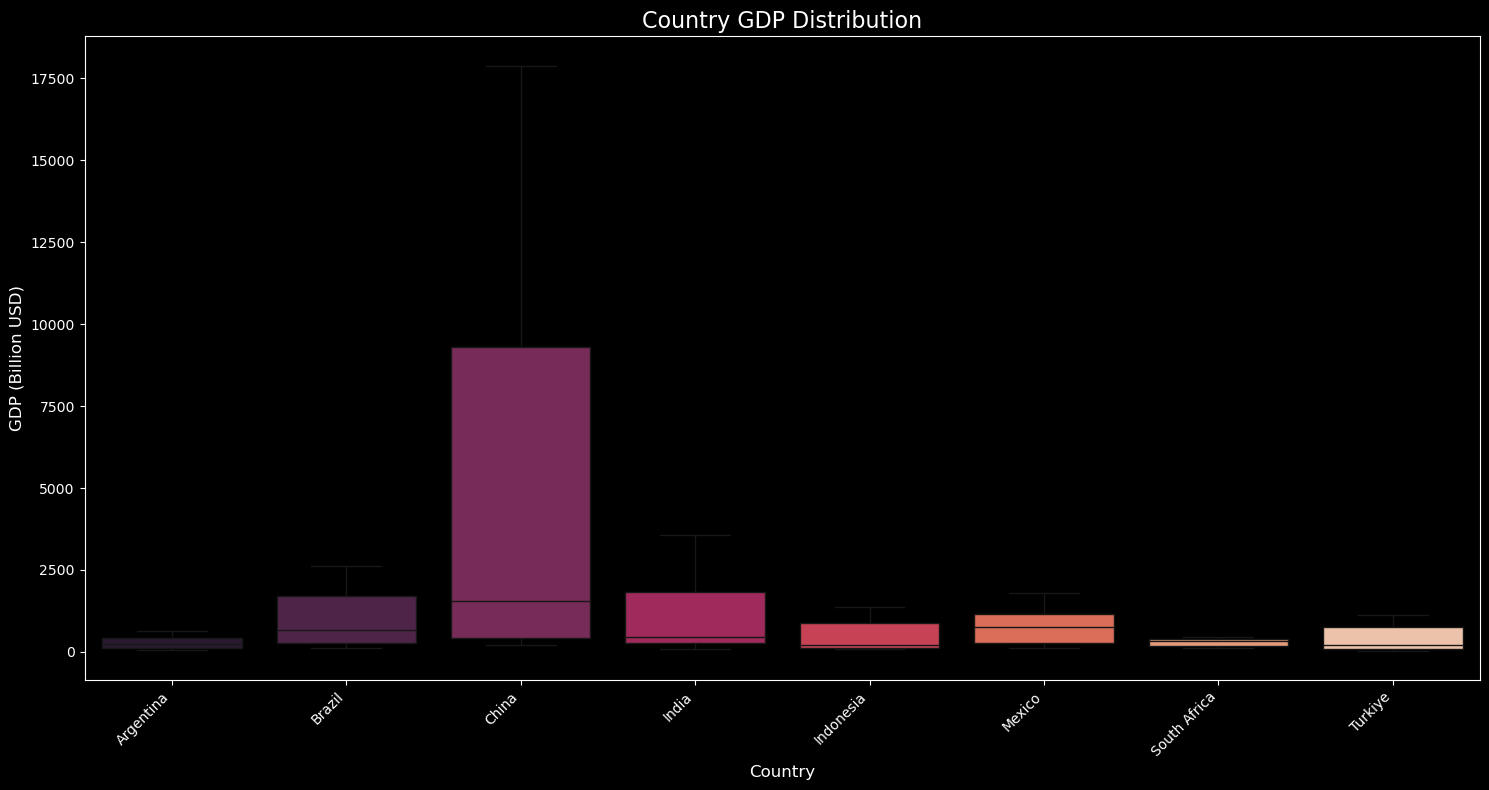

In [183]:
plt.figure(figsize=(15, 8))

sns.boxplot(data=df_final, x='Country', y='GDP_Billion_USD', palette='rocket')
plt.title('Country GDP Distribution', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('GDP (Billion USD)', fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

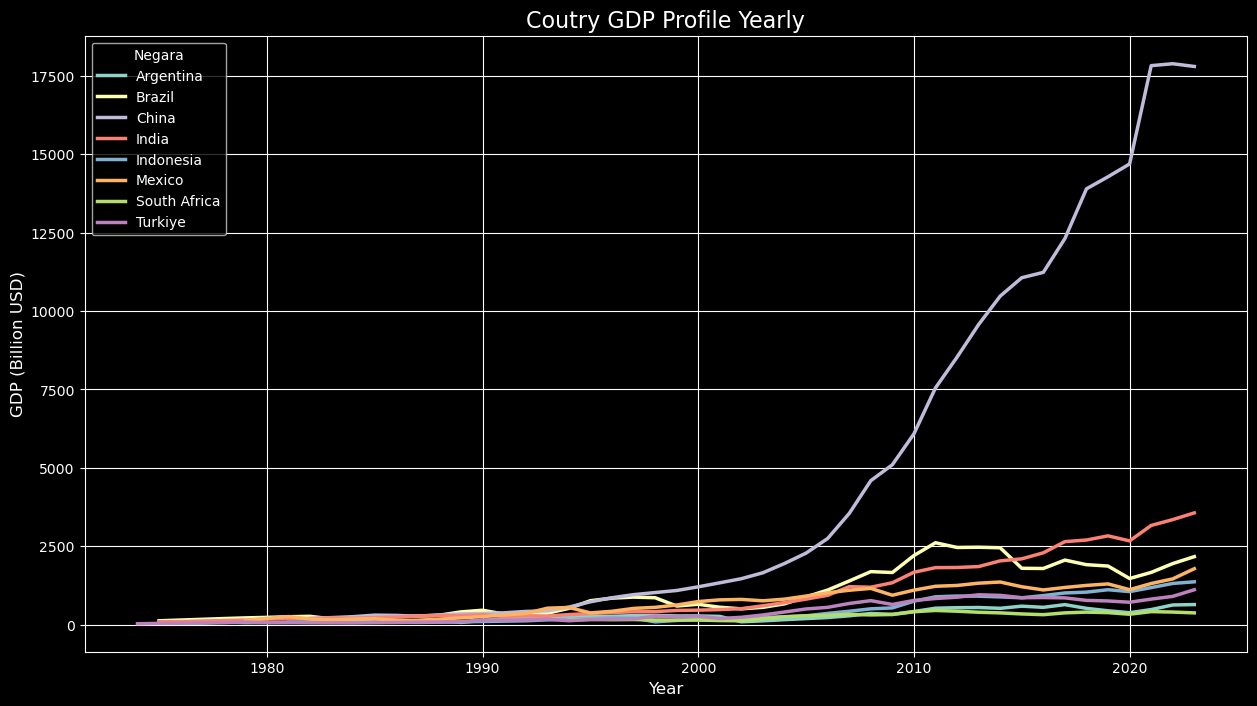

In [184]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_final, x='Year', y='GDP_Billion_USD', hue='Country', linewidth=2.5)

plt.title('Coutry GDP Profile Yearly', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('GDP (Billion USD)', fontsize=12)

plt.legend(title='Negara')
plt.grid(True)
plt.show()

China is the dominant economic power among this group of countries, with explosive GDP growth since 2000.

There are significant differences in economic growth trajectories across countries. Some countries (such as China, India, and Brazil) have shown strong and sustained growth, while others (such as Argentina and South Africa) have shown more limited or stagnant growth.

#### <b> Export Statistics

In [185]:
# Descriptive statistic export variabel
stats_export_per_country = df_final.groupby('Country')['Export_Billion_USD'].describe()

print("\nExport (Billion USD):")
stats_export_per_country


Export (Billion USD):


,count,mean,std,min,25%,50%,75%,max
Country,,,,,,,,
Argentina,48.0,44.395533,32.936107,4.691000,11.693750,36.482825,75.203013,106.808663
Brazil,49.0,129.737226,121.498270,9.939000,30.205000,64.416995,239.286456,420.789195
China,42.0,1169.747562,1301.731456,24.729000,86.119500,359.020658,2403.964296,3989.644347
India,49.0,198.320954,238.716538,5.636969,15.697156,53.305746,443.164297,811.089762
Indonesia,43.0,108.758175,85.760728,15.972000,35.689500,70.456621,178.903393,323.276096
Mexico,45.0,222.927101,195.231540,16.053000,41.757000,181.306292,405.863296,671.422944
South Africa,30.0,85.893984,38.940441,30.973638,39.172391,98.811143,117.108827,147.379250
Turkiye,50.0,100.201860,105.493499,2.018000,12.192000,52.952500,187.626000,368.693000


C:\Users\hilla\AppData\Local\Temp\ipykernel_24348\1467577551.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




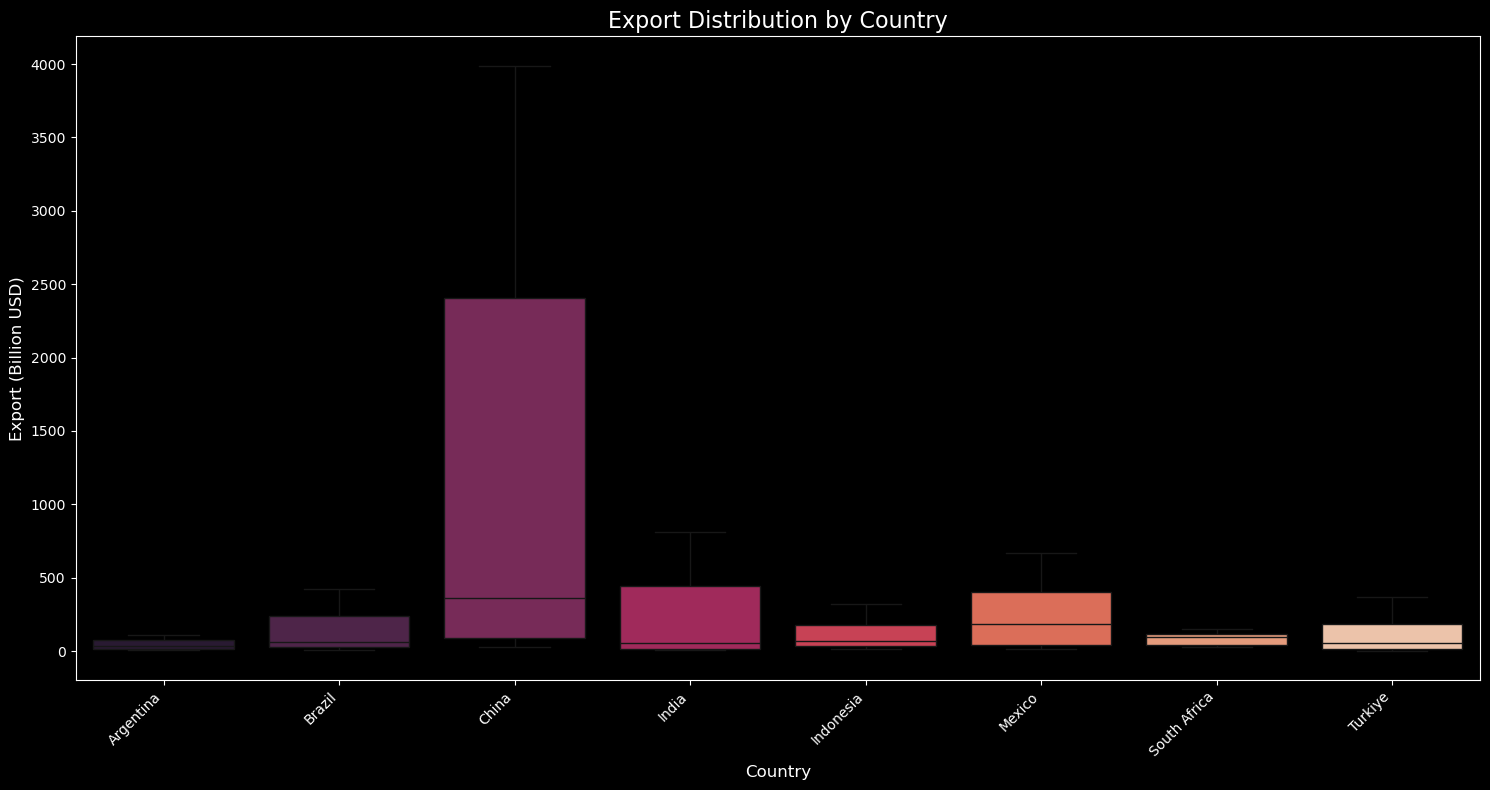

In [186]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_final, x='Country', y='Export_Billion_USD', palette='rocket')

plt.title('Export Distribution by Country', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Export (Billion USD)', fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

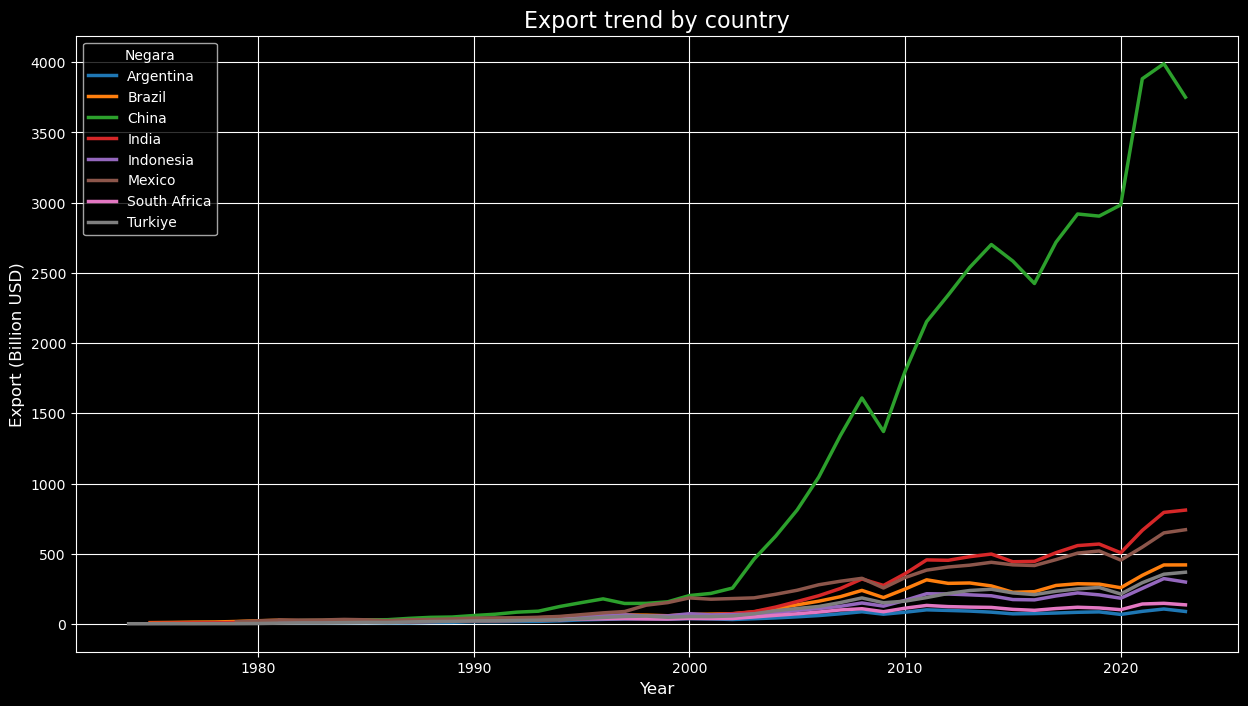

In [187]:
# Country export trend
fig, ax = plt.subplots(figsize=(15, 8))
countries = df_final['Country'].unique()
colors = sns.color_palette('tab10', n_colors=len(countries))

for i, country in enumerate(countries):
    country_df = df_final[df_final['Country'] == country]
    ax.plot(country_df['Year'], country_df['Export_Billion_USD'], 
            label=country, color=colors[i], linewidth=2.5)

ax.set_title('Export trend by country', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Export (Billion USD)', fontsize=12)

ax.legend(title='Negara')
ax.grid(True)

plt.show()

China's explosive and steady export growth since the early 2000s, reaching values well above 3000 Billion USD in the most recent period, while other countries such as Mexico, India, and Brazil show more moderate growth below 1000 Billion USD, and Argentina and South Africa tend to stagnate at much lower values. China has very high median, mean, and maximum export values (median ~359 Billion USD, mean ~1170 Billion USD, and maximum ~3990 Billion USD), as well as a large standard deviation (~1301 Billion USD) reflecting both its rapid growth rate and high variability over time.

## Trend Analysis

#### <b> Total Debt of each country year over year

In [188]:
# Buat line plot interaktif untuk Total Utang
fig = px.line(
    df_final,
    x='Year',
    y='Total_Debt_Billion_USD',
    color='Country',
    title='Year over Year Total Debt (Billion USD)',
    labels={
        "Total_Debt_Billion_USD": "Total Debt",
    },
    template='plotly_white'
)

# Tampilkan plotnya
fig.show()

The total debt trends of several countries. The most prominent is China, which experienced a very large and rapid increase in debt, especially after 2005, far exceeding other countries.

In [189]:
fig = px.line(
    df_final,
    x='Year',
    y='Total_Debt_Billion_USD',
    color='Country',
    title='Year over Year Total Debt (Billion USD)',
    labels={
        "Total_Debt_Billion_USD": "Total Debt",
    },
    template='plotly_white'
)

# Highlight China: Iterasi melalui setiap jejak dan modifikasi propertinya
for trace in fig.data:
    if trace.name == 'China':
        # Jadikan garis China lebih tebal dan berwarna merah
        trace.line.width = 4
        trace.line.color = 'red'
    else:
        # Jadikan garis negara lain lebih tipis dan sedikit transparan
        trace.opacity = 0.3
        trace.line.width = 1

# Tampilkan plotnya
fig.show()

China showed the most significant and explosive increase in debt among all countries, especially after 2009. China's debt soared from below 500 Billion USD to a peak of nearly 2600 Billion USD around 2020-2021.

In [190]:
# Exclude China from the DataFrame before plotting
df_filtered = df_final[df_final['Country'] != 'China']

# Define countries to highlight
highlight_countries = ['Mexico', 'Brazil', 'India']

# Create the interactive line plot for Total Debt
fig = px.line(
    df_filtered, # Use the filtered DataFrame here
    x='Year',
    y='Total_Debt_Billion_USD',
    color='Country',
    title='Year over Year Total Debt (Billion USD) - Excluding China', # Updated title for clarity
    labels={
        "Total_Debt_Billion_USD": "Total Debt",
    },
    template='plotly_white'
)

# Highlight Mexico, Brazil, and India: Iterate through each trace and modify its properties
for trace in fig.data:
    # Check if the current trace's name (country) is one of the countries to highlight
    if trace.name in highlight_countries:
        # Make the lines for these countries thicker
        trace.line.width = 4
        # You can optionally set a specific color here if you want them all to be the same highlight color,
        # otherwise, Plotly will keep their default assigned colors which are often distinct enough.
        # Example: trace.line.color = 'blue'
    else:
        # Make other country lines thinner and semi-transparent
        trace.opacity = 0.3
        trace.line.width = 1

# Display the plot
fig.show()

There are clear differences in the rate of debt growth among these countries, from fast growth (Brazil, Mexico, India) to moderate (Indonesia, Turkey) and slow/stagnant (Argentina, South Africa).

Excluding China, this chart reveals that Brazil, Mexico, and India are the countries with the largest debt accumulations among the remaining group, indicating substantial debt growth over time.

In [191]:
# Trim data to the years 2000 through 2023
df_trimmed = df_final[(df_final['Year'] >= 2000) & (df_final['Year'] <= 2023)].copy()

# Create the interactive line plot for Total Debt with trimmed data
fig = px.line(
    df_trimmed, # Use the trimmed DataFrame here
    x='Year',
    y='Total_Debt_Billion_USD',
    color='Country',
    title='Year over Year Total Debt (Billion USD) (2000-2023)', # Updated title
    labels={
        "Total_Debt_Billion_USD": "Total Debt",
    },
    template='plotly_white'
)

# Add a vertical line at the year 2008
fig.add_vline(
    x=2008,
    line_dash="dash",
    line_color="gray",
    annotation_text="Global Financial Crisis", # Add annotation text
    annotation_position="top right",
    annotation_font_size=10,
    annotation_font_color="gray"
)

# Display the plot
fig.show()

In [192]:
# Exclude China from the trimmed DataFrame
df_trimmed_no_china = df_trimmed[df_trimmed['Country'] != 'China'].copy()

# Create the interactive line plot for Total Debt with trimmed and China-excluded data
fig = px.line(
    df_trimmed_no_china, # Use the trimmed and China-excluded DataFrame here
    x='Year',
    y='Total_Debt_Billion_USD',
    color='Country',
    title='Year over Year Total Debt (Billion USD) (2000-2023) - Excluding China', # Updated title for clarity
    labels={
        "Total_Debt_Billion_USD": "Total Debt",
    },
    template='plotly_white'
)

# Add a vertical line at the year 2008
fig.add_vline(
    x=2008,
    line_dash="dash",
    line_color="gray",
    annotation_text="Global Financial Crisis", # Add annotation text
    annotation_position="top right",
    annotation_font_size=10,
    annotation_font_color="gray"
)

# Display the plot
fig.show()

Faster debt growth is seen after 2008 for most of them, albeit at varying rates. Countries like Indonesia and Turkey also experienced moderate debt increases, while Argentina and South Africa showed slower debt accumulation and remained at the lowest levels. Overall, both charts confirm that the 2008 GFC appears to have been a turning point for many countries in debt accumulation, with many experiencing faster debt increases post-crisis, with China leading the way in debt accumulation on an unprecedented scale.

#### <b> Which country consistently has the heaviest debt burden relative to its economic strength?

In [193]:
# Order country by GDP/Debt Ratio
median_order = df_final.groupby('Country')['Debt_to_GDP_Ratio'].median().sort_values(ascending=False).index

# Boxplot Ratio distribution
fig = px.box(
    df_final,
    x='Country',
    y='Debt_to_GDP_Ratio',
    color='Country', 
    category_orders={'Country': median_order}, # 
    title='Country Debt/GDP Ratio',
    labels={
        "Debt_to_GDP_Ratio": "Debt/GDP (%)"
    },
    template='plotly_white'
)

In [194]:
# Memperbarui tampilan agar lebih rapi
fig.update_layout(
    xaxis_title="Country",
    yaxis_title=" Debt/GDP (%)",
    showlegend=False # Sembunyikan legenda karena warna sudah jelas
)

# 3. Tampilkan plot interaktifnya
fig.show()

Argentina has the highest and most variable debt burden, often exceeding 100%. Countries like Turkey, Indonesia, and Mexico have intermediate ratios. Meanwhile, China, India, Brazil, and South Africa exhibit lower and more stable debt/GDP ratios, with China having the lowest, indicating relatively small debt compared to the size of its economy.

In [195]:
fig = px.line(
    df_final,
    x='Year',
    y='Debt_to_GDP_Ratio',
    color='Country', 
    title='Debt/GDP Ratio',
    labels={
        "Debt_to_GDP_Ratio": "Debt/GDP (%)"
    },
    template='plotly_white'
)

fig.show()

In [204]:
# Countries to highlight
highlight_countries = ['China', 'Indonesia', 'Argentina']

# Create the interactive line plot for Debt/GDP Ratio
fig = px.line(
    df_final,
    x='Year',
    y='Debt_to_GDP_Ratio',
    color='Country',
    title='Debt/GDP Ratio',
    labels={
        "Debt_to_GDP_Ratio": "Debt/GDP (%)"
    },
    template='plotly_white'
)

# Highlight China, Indonesia, and Argentina: Iterate through each trace and modify its properties
for trace in fig.data:
    # Check if the current trace's name (country) is one of the countries to highlight
    if trace.name in highlight_countries:
        # Make the lines for these countries thicker
        trace.line.width = 4
        # Optionally, you can set a specific color here if you want them all to be the same highlight color,
        # otherwise, Plotly will keep their default assigned colors which are often distinct enough.
        # Example: trace.line.color = 'blue'
    else:
        # Make other country lines thinner and semi-transparent
        trace.opacity = 0.3
        trace.line.width = 1

fig.show()

The surge in debt/GDP ratios experienced by Argentina and Indonesia indicates their acute economic vulnerability to external shocks and domestic crises. In Indonesia's case, the drastic spike in the late 1990s is closely related to the 1997-1998 Asian Financial Crisis, where the severe depreciation of the rupiah exponentially increased the value of external debt in local currency, while GDP shrank. Similarly, Argentina experienced a significant spike in the early 2000s, mirroring the economic crisis and debt default of 2001-2002, where a combination of a severe recession and currency devaluation skyrocketed its debt ratio.

China's low and stable debt/GDP position, despite its very large total debt volume, demonstrates extraordinary economic strength; China's rapid and sustained GDP growth has far outpaced its rate of debt accumulation, ensuring that its debt size remains proportionate and well-managed relative to its economic capacity.

#### <b> What is the proportion of debt in each country? Do countries with high debt burdens also tend to take on riskier debt (short-term debt)?

In [ ]:
import plotly.express as px

fig = px.line(
    df_final,
    x='Year',
    y='Short_Term_Debt_Ratio',
    color='Country', 
    title='Short term dept portion Year over Year',
    labels={
        "Short_Term_Debt_Ratio": "short term debt (%)"
    },
    template='plotly_white'
)

fig.show()

In [ ]:
fig = px.line(
    df_final,
    x='Year',
    y='Short_Term_Debt_Billion_USD',
    color='Country',
    title='total Short term debt (Billion USD)',
    labels={
        "Short_Term_Debt_Billion_USD": "Short term debt",
    },
    template='plotly_white'
)

# Tampilkan plot interaktifnya
fig.show()

China has a much larger absolute short-term debt burden than other countries, soaring to over $1,400 billion, and consistently displays a high proportion of short-term debt relative to its total debt, often above 50%.
This is likely due to China's low debt-to-GDP ratio, while other countries tend to have larger ones. Therefore, China may be more aggressive in taking on short-term debt than other countries.

In [206]:
# Countries to highlight
highlight_countries = ['Argentina', 'Indonesia']

# Create the interactive line plot for Short Term Debt Ratio
fig = px.line(
    df_final,
    x='Year',
    y='Short_Term_Debt_Ratio',
    color='Country',
    title='Short Term Debt Portion Year over Year',
    labels={
        "Short_Term_Debt_Ratio": "Short Term Debt (%)" # Update y-axis label
    },
    template='plotly_white'
)

# Highlight Argentina and Indonesia: Iterate through each trace and modify its properties
for trace in fig.data:
    # Check if the current trace's name (country) is one of the countries to highlight
    if trace.name in highlight_countries:
        # Make the lines for these countries thicker
        trace.line.width = 4
        # Optionally, you can set a specific color here for highlights.
        # Example: if trace.name == 'Argentina': trace.line.color = 'blue'
        #          elif trace.name == 'Indonesia': trace.line.color = 'red'
    else:
        # Make other country lines thinner and semi-transparent
        trace.opacity = 0.3
        trace.line.width = 1

fig.show()

Argentina exhibits a very high and unstable debt/GDP burden, accompanied by a volatile proportion of short-term debt, particularly early in the period and rising again later in the period. Similarly, Indonesia, which also experienced a sharp surge in debt/GDP due to the crisis, exhibited a very high proportion of short-term debt in the late 1990s, indicating that countries with high debt burdens and/or crisis vulnerabilities tend to take on or are forced to take on riskier, short-term debt.

#### <b> Which country has the most export revenue "drained" to pay off debt installments?

In [208]:
# Calculate median Debt_Service_as_%_of_Exports for each country for sorting
median_order = df_final.groupby('Country')['Debt_Service_as_%_of_Exports'].median().sort_values(ascending=False).index

# Create an interactive box plot with a new color palette
fig = px.box(
    df_final,
    x='Country',
    y='Debt_Service_as_%_of_Exports',
    color='Country',  # Assign different colors for each country
    category_orders={'Country': median_order}, # Order countries by median
    title='Interactive Comparison of Debt Payment Burden', # Updated title
    labels={
        "Country": "Country", # Updated x-axis label
        "Debt_Service_as_%_of_Exports": "Debt Payment Burden (% of Exports)" # Updated y-axis label
    },
    template='plotly_white',
)

# Update plot layout
fig.update_layout(
    xaxis_title="Country", # Updated x-axis title
    yaxis_title="Debt Payment Burden (% of Exports)", # Updated y-axis title
    showlegend=False # Hide legend if colors are already by Country and axis labels are clear
)

# Display the interactive plot
fig.show()

Brazil exhibits the highest debt service burden of all countries. The median is in the 45-50% range, meaning that half of Brazil's observed data indicates that 45-50% or more of its export revenues are allocated to debt service.

#### <b> Is the increase in debt accompanied by commensurate economic growth?

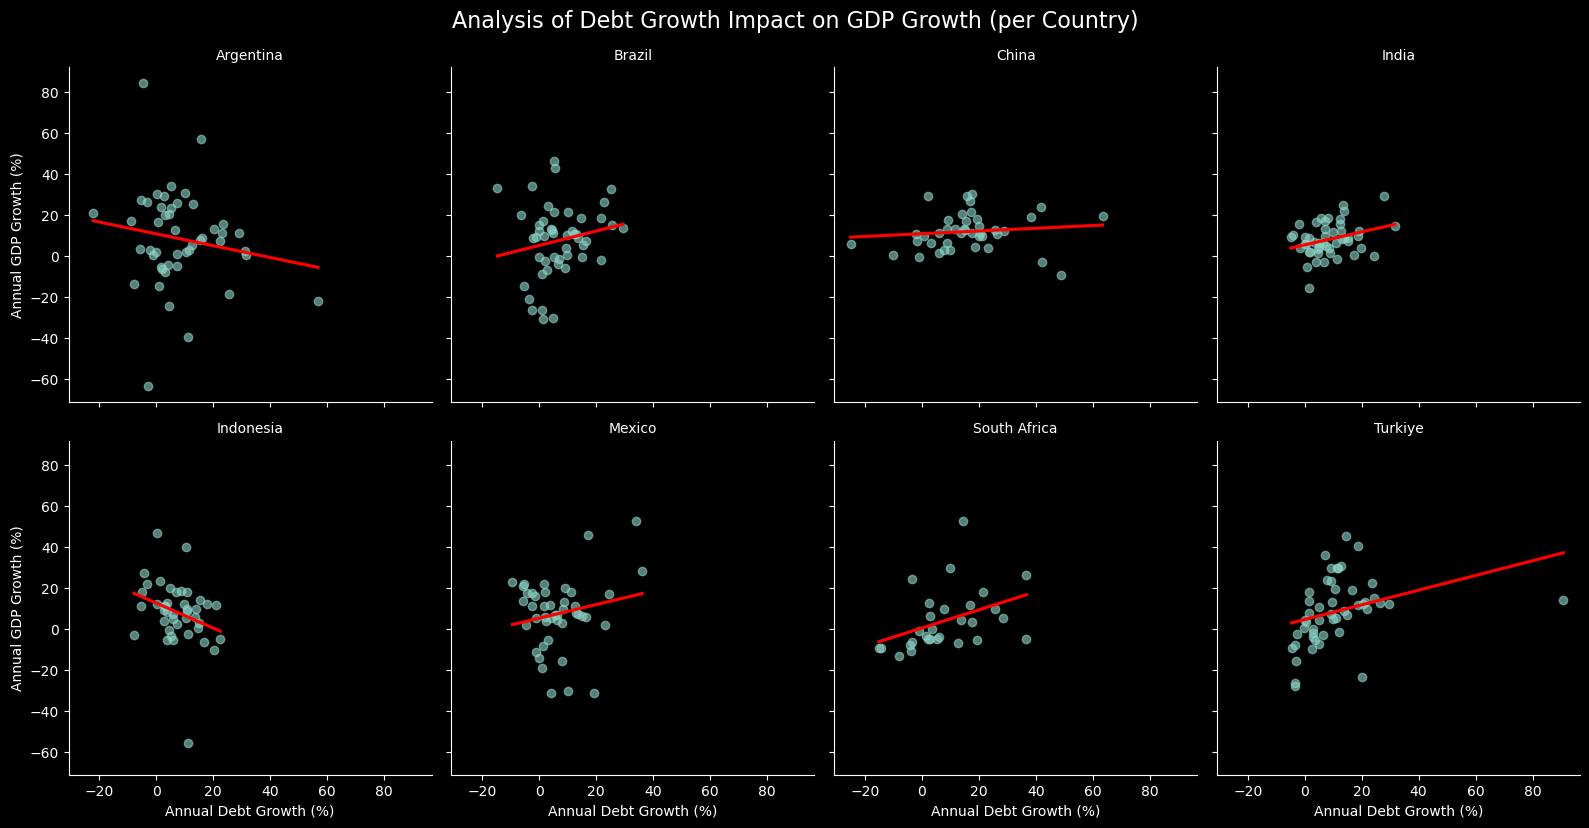

In [207]:
# lmplot is ideal because it combines regression with faceting
g = sns.lmplot(
    data=df_final,
    x='Debt_Growth_%',
    y='GDP_Growth_%',
    col='Country',             # Create separate plot columns for each country
    col_wrap=4,                # Limit to 4 plots per row for neatness
    height=4,                  # Height of each plot
    ci=None,                   # Do not show confidence interval for cleaner plots
    scatter_kws={'alpha': 0.6},# Set scatter point transparency
    line_kws={'color': 'red'}  # Make all regression lines red
)

# Set the main title
g.fig.suptitle('Analysis of Debt Growth Impact on GDP Growth (per Country)', y=1.03, fontsize=16)

# Set axis labels
g.set_axis_labels('Annual Debt Growth (%)', 'Annual GDP Growth (%)')

# Adjust the title of each subplot
g.set_titles("{col_name}")

plt.show()

In [210]:
# Get unique list of countries to loop through
countries = df_final['Country'].unique()

# Loop through each country to create separate plots
for country in countries:
    
    # Filter data for the current country
    country_df = df_final[df_final['Country'] == country]
    
    # 1. Create the figure canvas
    fig = go.Figure()

    # 2. Add the first trace for GDP on the left Y-axis
    fig.add_trace(go.Scatter(
        x=country_df['Year'], 
        y=country_df['GDP_Billion_USD'],
        name='GDP (Billion USD)',
        mode='lines+markers',
        yaxis='y1'
    ))

    # 3. Add the second trace for Total Debt on the right Y-axis
    fig.add_trace(go.Scatter(
        x=country_df['Year'], 
        y=country_df['Total_Debt_Billion_USD'],
        name='Total Debt (Billion USD)',
        mode='lines+markers',
        yaxis='y2'
    ))

    # 4. Set layout, title, and both Y-axes
    fig.update_layout(
        title_text=f'GDP vs. Total Debt Trend for {country}', # Updated title
        xaxis_title='Year', # Updated x-axis title
        # Left Y-axis settings (Y1)
        yaxis=dict(
            title='GDP (Billion USD)', # Updated Y1 title
            tickfont=dict(color='#1f77b4') # Blue color for GDP
        ),
        # Right Y-axis settings (Y2)
        yaxis2=dict(
            title='Total Debt (Billion USD)', # Updated Y2 title
            tickfont=dict(color='#ff7f0e'), # Orange color for Total Debt
            overlaying='y', # Overlay on primary Y-axis
            side='right' # Position Y2 on the right side
        ),
        legend=dict(x=0.1, y=0.9) # Position legend
    )

    # 5. Display the plot
    fig.show()

The relationship between debt increases and corresponding economic growth varies widely across countries. For most countries, such as China, India, Mexico, and Turkey, debt increases are generally accompanied by commensurate or even faster GDP growth, as indicated by a positive correlation between debt and GDP growth, as well as parallel trends in the absolute graphs, indicating productive use of debt.

However, for Argentina and Indonesia, debt increases are often not accompanied by commensurate economic growth, and are sometimes even negatively correlated with GDP growth, suggesting potential inefficiencies or debt accumulation amid economic hardship.

#### <b> Correlation analysis

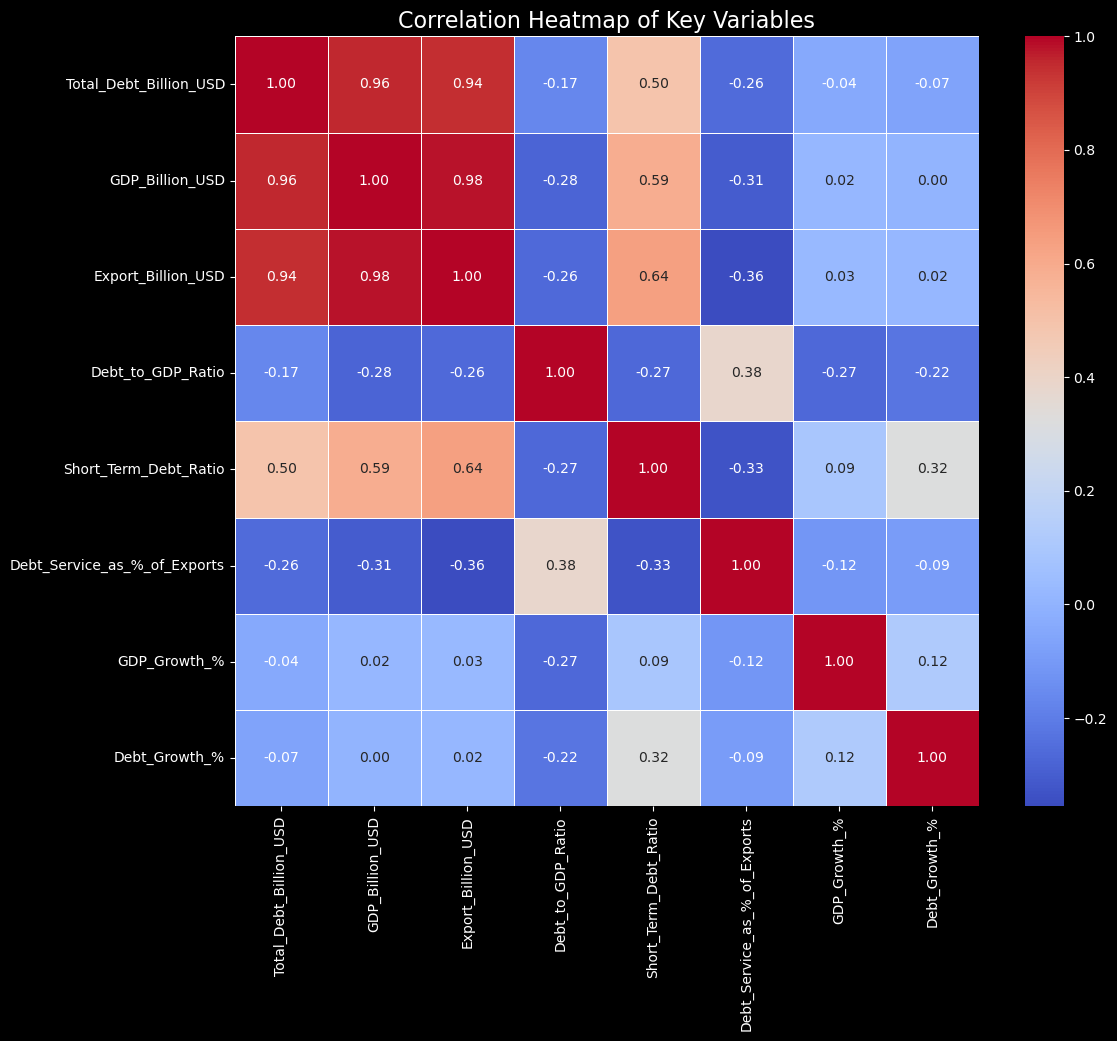

In [211]:
# Select relevant numerical columns for correlation analysis
correlation_cols = [
    'Total_Debt_Billion_USD',
    'GDP_Billion_USD',
    'Export_Billion_USD',
    'Debt_to_GDP_Ratio',
    'Short_Term_Debt_Ratio',
    'Debt_Service_as_%_of_Exports',
    'GDP_Growth_%',
    'Debt_Growth_%'
]

# Calculate the correlation matrix
# Use only complete rows for all these columns for accurate calculation
correlation_matrix = df_final[correlation_cols].dropna().corr()

# Create the heatmap visualization
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,              # Display numbers inside each cell
    cmap='coolwarm',         # Use a blue-red color palette
    fmt=".2f",               # Format numbers to 2 decimal places
    linewidths=.5            # Add lines between cells
)

# Set the title
plt.title('Correlation Heatmap of Key Variables', fontsize=16)
plt.show()

In [ ]:
df_no_china = df_final[df_final['Country'] != 'China']
# Get unique list of countries to loop through (excluding China)
countries_no_china = df_no_china['Country'].unique()

# Assign a specific color from a palette to each country for consistent plotting
color_palette = px.colors.qualitative.G10
color_map = {country: color_palette[i % len(color_palette)] for i, country in enumerate(countries_no_china)}
# -------------------------

# 3. Create a canvas with 3 subplots (rows, cols)
fig = make_subplots(
    rows=3, cols=1, 
    shared_xaxes=True, # Share the X-axis across subplots
    subplot_titles=('GDP Trend', 'Total Debt Trend', 'Export Trend') # Titles for each subplot
)

# 4. Loop through each country and plot its data with the predefined colors
for country in countries_no_china:
    country_df = df_no_china[df_no_china['Country'] == country]
    country_color = color_map[country] # Get the specific color for this country
    
    # Plot GDP
    fig.add_trace(go.Scatter(
        x=country_df['Year'], y=country_df['GDP_Billion_USD'], mode='lines', 
        name=country, legendgroup=country, line=dict(color=country_color) # Use the determined color
    ), row=1, col=1)
    
    # Plot Total Debt
    fig.add_trace(go.Scatter(
        x=country_df['Year'], y=country_df['Total_Debt_Billion_USD'], mode='lines', 
        name=country, legendgroup=country, showlegend=False, line=dict(color=country_color) # Use the same color, hide legend here
    ), row=2, col=1)
    
    # Plot Exports
    fig.add_trace(go.Scatter(
        x=country_df['Year'], y=country_df['Export_Billion_USD'], mode='lines', 
        name=country, legendgroup=country, showlegend=False, line=dict(color=country_color) # Use the same color, hide legend here
    ), row=3, col=1)

# 5. Set layout and main title
fig.update_layout(
    height=900, # Set the overall height of the figure
    title_text='GDP, Debt, and Export Trends (Excluding China)', # Main title of the plot
    template='plotly_white', # Set the plot theme
    legend_title_text='Country' # Title for the legend
)

# Set Y-axis labels for each subplot
fig.update_yaxes(title_text="GDP (Billion USD)", row=1, col=1)
fig.update_yaxes(title_text="Total Debt (Billion USD)", row=2, col=1)
fig.update_yaxes(title_text="Exports (Billion USD)", row=3, col=1)

# Display the interactive plot
fig.show()

there is a correlation between debt data, GDP and exports